# Simulate Neuronal Processes

This notebook takes in an RoI file from FIJI, estimates the neuronal radius, and simulates tracks in 3D over the process.

In [3]:
import sdt
import math
import roifile
import numpy as np
import pandas as pd
import seaborn as sns
from sdt import roi as roi
from matplotlib  import cm
from scipy.special import gamma
from matplotlib import pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator, interp2d

## Inputs

These are the RoI file and simulation inputs.  We default to four total states - two diffusion coefficients, "fast" diffusion with diffusion coefficient 2 um^2/s and "slow" with 1 um^2/s, and two immobile states defined by Hurst coefficients.

In [12]:
roi_filename = r'/scratch/inode/uqakilga/DL-MSS/MyFramework/GreenRoI.roi'

# Image size in pixels
image_size = (512, 512)
# How many tracks do we simulate?
number_of_simulated_tracks = 10000
# Which diffusion coefficients are "slow" and "fast"
diffusion_coefficients = [1.0, 2.0]
# Immobile state hurst coefficients
hurst_coefficients     = [[0.1, 0.2], [0.7, 0.8]]
# Minimum track and track segment lengths
minimum_track_length, minimum_tracklet_length = 10, 5

# Immobile state coefficients (See Marloes' paper for details)
M = 20
beta = 50
n_interval = 10

# Pixel size in um
pixsize = 0.1
t = 0.032

# Probability transition matrix for the states
P = np.ones((len(hurst_coefficients) + len(diffusion_coefficients), len(hurst_coefficients) + len(diffusion_coefficients)))
P *= 1.0/(P.shape[0]**2 - P.shape[0])
for i in range(P.shape[0]):
    P[i,i] = 0.8

In [5]:
processRoIsName     = roi_filename
try:
    processRoIsFile     = roifile.ImagejRoi.fromfile(processRoIsName)
except:
    print("Could not open ", processRoIsName)

roiFull = processRoIsFile.coordinates()
roiPath= roi.PathROI([list(l) for l in roiFull])

Let's define the RoI edges, smooth them some number of times, and define the orthogonal vectors to the edges.

In [6]:
dx, dy = roiFull[1:,0] - roiFull[:-1,0], roiFull[1:,1] - roiFull[:-1,1]

for i in range(10):
    dx, dy = (dx[:-1] + dx[1:])/2.0, (dy[:-1] + dy[1:])/2.0
    dx, dy = np.append(dx, dx[-1]), np.append(dy, dy[-1])

do, doT = [], []
for i in range(len(dx)):
    do_, doT_ = [dy[i], -dx[i]], [dx[i], dy[i]]
    do.append(do_/np.linalg.norm(do_))
    doT.append(doT_/np.linalg.norm(doT_))
do, doT = np.array(do), np.array(doT)

vec, vecT = [], []
for i in range(len(dx)):
    vec_, vecT_ = [dy[i], -dx[i]], [dx[i], dy[i]]
    vec.append(vec_/np.linalg.norm(vec_))
    vecT.append(vecT_/np.linalg.norm(vecT_))
vec, vecT = np.array(vec), np.array(vecT)

origins = np.array([(x,y) for x, y in zip(roiFull[:,0], roiFull[:,1])])

## Radius Determination

Let's test our simple algorithm.  We choose the closest edge that is at least 15 pixels away, with the edges facing each other (the dot product is negative), and the extrpolation of the edge orthogonal vector is within 3 pixels of the edge.  This defines the diameter of the process defined from the center of the edge extrapolation.

i:  0


/tmp/ipykernel_48133/2626220259.py:8: RuntimeWarning: divide by zero encountered in float_scalars
  y_at_j =  roiFull[i,1] + do[i,1]/do[i,0]*(roiFull[j,0] - roiFull[i,0])
/tmp/ipykernel_48133/2626220259.py:8: RuntimeWarning: invalid value encountered in float_scalars
  y_at_j =  roiFull[i,1] + do[i,1]/do[i,0]*(roiFull[j,0] - roiFull[i,0])


i:  1000
i:  2000
i:  3000


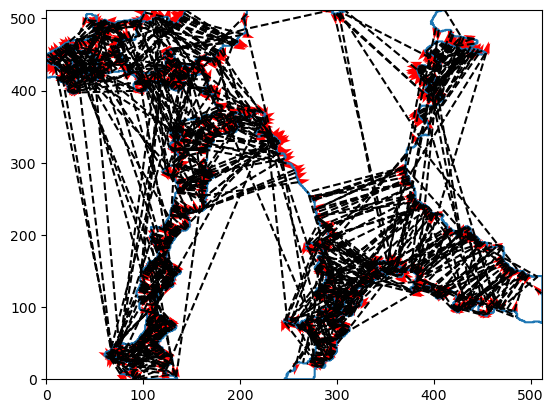

In [7]:
plt.plot(roiFull[:,0], roiFull[:,1])
indices_matched, posx, posy, poscx, poscy, posr, posvx, posvy = [], [], [], [], [], [], [], []
for i in range(0, len(roiFull[:,0])-1, 2):
    if i % 1000 == 0:
        print("i: ", i)
    best_index, matched, dist = -1.0, False, 150
    for j in range(0, len(roiFull[:,1])-1, 2):
        y_at_j =  roiFull[i,1] + do[i,1]/do[i,0]*(roiFull[j,0] - roiFull[i,0])
        ys1 = roiFull[j,1]   if roiFull[j,1] > roiFull[j,1] else roiFull[j+1,1]
        ys2 = roiFull[j+1,1] if roiFull[j,1] > roiFull[j,1] else roiFull[j,1]
        tempdist = np.sqrt((origins[i,0] - origins[j,0])**2 + (origins[i,0] - origins[j,0])**2)
        if tempdist < dist and tempdist > 15.0 and np.dot(do[i], do[j]) < 0.0\
            and i != j and y_at_j < ys1 + 3 and y_at_j >= ys2 - 3 :
            indices_matched.append(j)
            matched = True
            dist = np.sqrt((origins[i,0] - origins[j,0])**2 + (origins[i,0] - origins[j,0])**2)
            
    if matched == False:
        indices_matched.append(-1)
    else:
        plt.plot([origins[i,0], origins[indices_matched[-1],0]], [origins[i,1], origins[indices_matched[-1],1]], 'k--')
        plt.quiver(origins[i,0], origins[i,1], do[i,0]/2.0, do[i,1]/2.0, color=['r','b','g'], scale=21)

        posx.append(origins[i,0])
        posy.append(origins[i,1])
        poscx.append((origins[i,0] + origins[indices_matched[-1],0])/2.0)
        poscy.append((origins[i,1] + origins[indices_matched[-1],1])/2.0)
        posr.append(np.sqrt((poscx[-1] - origins[i,0])**2 + (poscy[-1] - origins[i,1])**2))
        posvx.append((poscx[-1] - origins[i,0])/posr[-1])
        posvy.append((poscy[-1] - origins[i,1])/posr[-1])
        
plt.xlim([0,512])
plt.ylim([0,512])
plt.show()

Now we filter out extrapolations that lie outside the RoI.  This removes most of the inaccurate extrpolations.

In [8]:
df = pd.DataFrame({'ox': posx, 'oy': posy, 'x': poscx, \
                  'y': poscy, 'r': posr, 'vx': posvx, 'vy': posvy})
df_fil = roiPath(df)
df_fil = df_fil.rename(columns={'ox': 'x', 'oy': 'y', 'x': 'cx', 'y': 'cy'})

posx_filtered, posy_filtered, posr_filtered, poscx_filtered, poscy_filtered, posvx_filtered, posvy_filtered = \
    df_fil['x'].to_numpy(), df_fil['y'].to_numpy(), df_fil['r'].to_numpy(), df_fil['cx'].to_numpy(), df_fil['cy'].to_numpy(), df_fil['vx'].to_numpy(), df_fil['vy'].to_numpy()

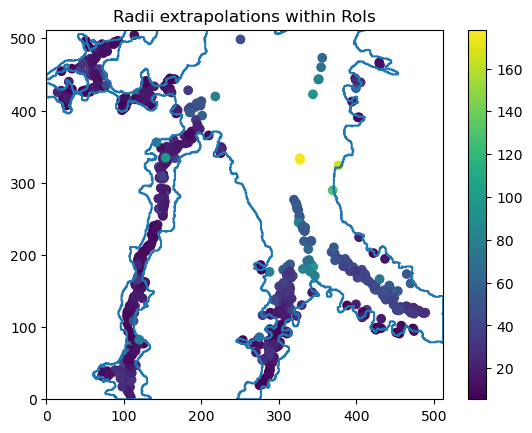

In [9]:
plt.plot(roiFull[:,0], roiFull[:,1])
plt.scatter(poscx_filtered, poscy_filtered, c=posr_filtered, cmap = 'viridis')
plt.colorbar()
plt.title('Radii extrapolations within RoIs')
plt.xlim([0,512])
plt.ylim([0,512])
plt.show()

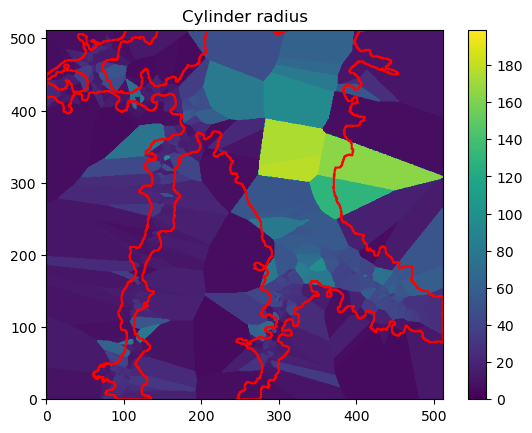

In [10]:
#number of data points per axis
n = 512
x_up = np.linspace(0.0, 512.0, n)
y_up = np.linspace(0.0, 512.0, n)
x3d, y3d = np.meshgrid(x_up, y_up)
z3d = griddata((poscx_filtered, poscy_filtered), posr_filtered, (x3d, y3d), method = "nearest")

#plt.pcolormesh(x_up, y_up, z3d, shading='auto')
plt.contourf(x_up, y_up, z3d, np.arange(0, 200, 1))
plt.plot(roiFull[:,0], roiFull[:,1], color='r')
plt.colorbar()
plt.title('Cylinder radius')
plt.show()

Most of this is borrowed from Marloes' code.  https://github.com/ismal/DL-MSS

In [13]:
# Simulation according to the book "Fractals" (Feder J, Springer, 1988) page 174, eq. 9.25
def fBm(t, ksi, H):
    sum1 = np.array([i ** (H - 0.5) * ksi[1 + n_interval * (M + t) - i] \
                     for i in np.arange(1, n_interval)]).sum()
    sum2 = np.array([((n_interval + i) ** (H - 0.5) - i ** (H - 0.5)) * ksi[1 + n_interval * (M - 1 + t) - i] \
                     for i in np.arange(1, n_interval * (M - 1))]).sum()
    return n_interval ** (-H) / gamma(H + 0.5) * (sum1 + sum2) 

X_tracks, Y_tracks, Z_tracks, S_tracks, SPOT_ID_tracks, Track_Len_tracks, D_tracks = [], [], [], [], [], [], []
spot_id = 0

for track in range(number_of_simulated_tracks):
    if track % 100 == 0:
        print("track: ", track)
    
    state = np.random.randint(len(hurst_coefficients), len(hurst_coefficients)+len(diffusion_coefficients))
    
    initial_X, initial_Y = image_size[0]*np.random.random(), image_size[1]*np.random.random()
    while len(roiPath(pd.DataFrame({'x': [initial_X], 'y': [initial_Y]}))) == 0:
        initial_X, initial_Y = image_size[0]*np.random.random(), image_size[1]*np.random.random()
        
    X, Y, Z, S, D, SPOT_ID, Track_Len = [], [], [], [], [], [], []
    
    track_length = max(minimum_track_length, int(np.random.exponential(beta)))
    
    spot_index, last = 0, False
    while spot_index < track_length:
        tracklet_length = minimum_tracklet_length + int(np.random.geometric(1 - P[state][state]))
        
        if spot_index + tracklet_length > track_length:
            tracklet_length -= tracklet_length + spot_index - track_length
            last = True
        
        d = -1
        if state < len(hurst_coefficients): # Diffusion
            d = diffusion_coefficients[state]
            x = np.random.normal(0, np.sqrt(2 * diffusion_coefficients[state] * t), size=tracklet_length) / pixsize
            y = np.random.normal(0, np.sqrt(2 * diffusion_coefficients[state] * t), size=tracklet_length) / pixsize         
        else: # Non-diffusive processes
            d = hurst_coefficients[state - len(diffusion_coefficients)][1]
            ksix = np.random.normal(0, 1, (M + tracklet_length + 1) * n_interval)
            x = \
                [fBm(j, ksix, hurst_coefficients[state - len(diffusion_coefficients)][0]) * hurst_coefficients[state - \
                len(diffusion_coefficients)][1] for j in np.arange(1, tracklet_length + 1)]
            ksiy = np.random.normal(0, 1, (M + tracklet_length + 1) * n_interval)
            y = \
                [fBm(j, ksiy, hurst_coefficients[state - len(diffusion_coefficients)][0]) * hurst_coefficients[state - \
                len(diffusion_coefficients)][1] for j in np.arange(1, tracklet_length + 1)]
            
        spot_index += tracklet_length
        
        for i in range(len(x)):
            X.append(x[i])
            Y.append(y[i])
            S.append(state)
            D.append(d)
        for j in range(len(x)):
            SPOT_ID.append(spot_id)
            spot_id += 1

        state = np.random.randint(0, len(hurst_coefficients)+len(diffusion_coefficients))

    X[0] += initial_X
    Y[0] += initial_Y

    for j in range(len(X)):
        Track_Len.append(len(X))
    
    X_tracks.append(np.cumsum(X))
    Y_tracks.append(np.cumsum(Y))
    S_tracks.append(S)
    D_tracks.append(D)
    SPOT_ID_tracks.append(SPOT_ID)
    Track_Len_tracks.append(Track_Len)

track:  0
track:  100
track:  200
track:  300
track:  400
track:  500
track:  600
track:  700
track:  800
track:  900
track:  1000
track:  1100
track:  1200
track:  1300
track:  1400
track:  1500
track:  1600
track:  1700
track:  1800
track:  1900
track:  2000
track:  2100
track:  2200
track:  2300
track:  2400
track:  2500
track:  2600
track:  2700
track:  2800
track:  2900
track:  3000
track:  3100
track:  3200
track:  3300
track:  3400
track:  3500
track:  3600
track:  3700
track:  3800
track:  3900
track:  4000
track:  4100
track:  4200
track:  4300
track:  4400
track:  4500
track:  4600
track:  4700
track:  4800
track:  4900
track:  5000
track:  5100
track:  5200
track:  5300
track:  5400
track:  5500
track:  5600
track:  5700
track:  5800
track:  5900
track:  6000
track:  6100
track:  6200
track:  6300
track:  6400
track:  6500
track:  6600
track:  6700
track:  6800
track:  6900
track:  7000
track:  7100
track:  7200
track:  7300
track:  7400
track:  7500
track:  7600
track:  770

Does the 3D projection onto the cylinder surface.  Assumes "x" lies along a cylinder aligned orthogonal to the edge vector at the center of the extrapolation.  Needs further validation.

In [ ]:
tracks_x, tracks_y, tracks_z, state, sim_par = [], [], [], [], []

for i in range(len(X_tracks)):
    
    if i % 100 == 0:
        print(i, " / ", len(X_tracks))
    
    trackPos = np.array([(x_, y_) for x_, y_ in zip(X_tracks[i], Y_tracks[i])])
        
    rs, cxs, cys, vxs, vys = [], [], [], [], []

    for j in range(len(X_tracks[i])):
        mindist, mini = 1e6, -1
        for k in range(len(poscx_filtered)):
            if np.sqrt((X_tracks[i][j] - poscx_filtered[k])**2 + (Y_tracks[i][j] - poscy_filtered[k])**2) < mindist:
                mindist = np.sqrt((X_tracks[i][j] - poscx_filtered[k])**2 + (Y_tracks[i][j] - poscy_filtered[k])**2)
                mini    = k

        rs .append(posr_filtered[mini])
        cxs.append(poscx_filtered[mini])
        cys.append(poscy_filtered[mini])
        vxs.append(posvx_filtered[mini])
        vys.append(posvy_filtered[mini])
        
    rs, cxs, cys, vxs, vys = np.array(rs), np.array(cxs), np.array(cys), np.array(vxs), np.array(vys)

    xtracks_init, y = X_tracks[i].copy(), Y_tracks[i].copy()
    xtracks_working = xtracks_init
    xtracks_working -= cxs
    y -= cys

    while len(xtracks_working[xtracks_working > 2*np.pi*rs]) + len(xtracks_working[xtracks_working < -2*np.pi*rs]) > 0:
        xtracks_working[xtracks_working > 2*np.pi*rs]  -= 2*np.pi*rs[xtracks_working > 2*np.pi*rs]
        xtracks_working[xtracks_working < -2*np.pi*rs] += 2*np.pi*rs[xtracks_working < -2*np.pi*rs]
    
    z = xtracks_working

    xtracks_working = rs*np.cos(np.arcsin(xtracks_working/rs))

    for j in range(len(vxs)):
        theta = math.atan2(vxs[j], vys[j])
        rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        xy = np.dot(rot, np.array([xtracks_working[j], y[j]]))
        xtracks_working[j], y[j] = xy[0], xy[1]        

    x = xtracks_working + cxs
    y = y + cys
    
    tracks_x.append(x)
    tracks_y.append(y)
    tracks_z.append(z)
    state.append(S_tracks[i])
    sim_par.append(D_tracks[i])

In [ ]:
# Plot of the edge vector x-component
n = 512
x_up = np.linspace(0.0, 512.0, n)
y_up = np.linspace(0.0, 512.0, n)
x3d, y3d = np.meshgrid(x_up, y_up)
z3d = griddata((posx_filtered, posy_filtered), posvx_filtered, (x3d, y3d), method = "nearest")

#plt.pcolormesh(x_up, y_up, z3d, shading='auto')
plt.contourf(x_up, y_up, z3d)
plt.plot(roiFull[:,0], roiFull[:,1], color='r')
plt.colorbar()
plt.title('Vector to surface x-component')
plt.show()

In [ ]:
# Plot of the edge vector x-component
n = 512
x_up = np.linspace(0.0, 512.0, n)
y_up = np.linspace(0.0, 512.0, n)
x3d, y3d = np.meshgrid(x_up, y_up)
z3d = griddata((posx_filtered, posy_filtered), posvy_filtered, (x3d, y3d), method = "nearest")

#plt.pcolormesh(x_up, y_up, z3d, shading='auto')
plt.contourf(x_up, y_up, z3d)
plt.plot(roiFull[:,0], roiFull[:,1], color='r')
plt.colorbar()
plt.title('Vector to surface y-component')
plt.show()

In [ ]:
# Build a pandas dataframe from the dataset
df_tracks = []
for i in range(len(X_tracks)):
    df_tracks.append(pd.DataFrame({'x': tracks_x[i], 'y': tracks_y[i], 'z': tracks_z[i], \
                                   'TRACK_ID': i*np.ones(len(tracks_x[i])), "STATE": state[i], \
                                  "DIFF_COEFF": sim_par[i]}))
df_tracks = pd.concat(df_tracks, ignore_index=True)
roi_tracks = roiPath(df_tracks)

In [ ]:
sns.kdeplot(x='x', y='y', data=df_tracks)
plt.xlim([0,512])
plt.ylim([0,512])
plt.title("Spot Density")
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(roiFull[:,0], roiFull[:,1], color='r', linewidth=2)
plt.scatter(roi_tracks['x'], roi_tracks['y'], c=roi_tracks['z'], cmap=cm.jet)
plt.xlim([0,512])
plt.ylim([0,512])
plt.colorbar()
plt.title("Z Position of Tracks")
plt.show()

In [ ]:
# Save to csv file
roi_tracks.to_csv(r'/scratch/inode/uqakilga/DL-MSS/MyFramework/simulated_tracks.csv')